In [1]:
import networkx as nx
import pandas as pd
from joblib import Parallel, delayed
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import plotly.express as px
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import numpy as np
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
import graph_tool.all as gt
from graph_tool.centrality import betweenness, pagerank
from graph_tool.inference import *
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon

import sqlite3


In [2]:
##################################
# Python SQLite Conversion Reader
##################################
last_db_path = None
sql_columns = []

class FromSQLite:
    pathDB = os.path.join(os.getcwd(), "basedata", "total_base_data.db")
    
    @staticmethod
    def infer_sql_type(dtype):
        if pd.api.types.is_integer_dtype(dtype):
            return "INTEGER"
        elif pd.api.types.is_float_dtype(dtype):
            return "REAL"
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            return "DATETIME"
        else:
            return "TEXT"  # Default to TEXT for other types

    @staticmethod
    def getData(SQL_columns='*', importer=None, exporter=None, year=None, product_code=None, value=None, quantity=None, table_name="base_data", path=pathDB):
        """
        Fetch data from SQLite with optional filters.

        Args:
            SQL_columns (str): Columns to select. Default is '*'.
            importer (list, optional): List of import countries. Default is None.
            exporter (list, optional): List of export countries. Default is None.
            year (list, optional): List of years. Default is None.
            product_code (list, optional): List of product codes. Default is None.
            value (float, optional): Minimum value. Default is None.
            quantity (float, optional): Minimum quantity. Default is None.
            table_name (str, optional): Name of the table in the database. Default is "base_data".
            path (str, optional): Path to the database file. Default is pathDB.

        Returns:
            pd.DataFrame: Filtered data.
        """
        if not os.path.exists(path):
            print(f"ERROR: Database file '{path}' does not exist.")
            return None

        query = f"SELECT {SQL_columns} FROM {table_name} WHERE 1=1"
        params = []
        
        if exporter:
            print('Getting exporter', end="")
            placeholders = ', '.join('?' for _ in exporter)
            query += f" AND export_country IN ({placeholders})"
            params.extend(exporter)

        if importer:
            print('Getting importer', end="")
            placeholders = ', '.join('?' for _ in importer)
            query += f" AND import_country IN ({placeholders})"
            params.extend(importer)

        if year:
            print('Getting years', end="")
            placeholders = ', '.join('?' for _ in year)
            query += f" AND year IN ({placeholders})"
            params.extend(year)

        if product_code:
            print('Getting product codes', end="")
            placeholders = ', '.join('?' for _ in product_code)
            query += f" AND code IN ({placeholders})"
            params.extend(product_code)

        if value:
            print('Getting value', end="")
            placeholders = ', '.join('?' for _ in value)
            query += f" AND value IN ({placeholders})"
            params.append(value)

        if quantity:
            print('Getting quantity', end="")
            placeholders = ', '.join('?' for _ in quantity)
            query += f" AND quantity IN ({placeholders})"
            params.append(quantity)

        try:
            with sqlite3.connect(path) as conn:
                df = pd.read_sql_query(query, conn, params=params)
        except sqlite3.OperationalError as e:
            print(f"SQL Error: {e}")
            return None

        return df

    def pushData(df, table_name='base_data', db_path=pathDB):
        """
        Push data into SQLite database, adding only new rows and handling missing columns.

        Args:
            df (pd.DataFrame): Data to push into the database.
            table_name (str): Target table name.
            db_path (str): Path to the SQLite database file.
        """
        global last_db_path, sql_columns  # Declare global variables

        db_path = db_path or FromSQLite.pathDB

        # Ensure the directory for the database exists
        if not os.path.exists(os.path.dirname(db_path)):
            os.makedirs(os.path.dirname(db_path))

        try:
            # Connect to the SQLite database
            with sqlite3.connect(db_path) as conn:
                cursor = conn.cursor()

                # Check if the table exists
                cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table_name}';")
                table_exists = cursor.fetchone() is not None

                if not table_exists:
                    # Create the table with the DataFrame's schema
                    print(f"Table '{table_name}' does not exist. Creating it...")
                    df.head(0).to_sql(table_name, conn, if_exists='replace', index=False)

                # Check if the database path is the same as the last call
                if db_path != last_db_path:
                    # Cache the SQL column names for the table
                    cursor.execute(f"PRAGMA table_info({table_name});")
                    sql_columns = [row[1] for row in cursor.fetchall()]  # Get column names
                    last_db_path = db_path

                # Check for missing columns
                df_columns = df.columns.tolist()
                print(df_columns)
                missing_in_sql = set(df_columns) - set(sql_columns)

                # Add missing columns to the table if any
                if missing_in_sql:
                    for column in missing_in_sql:
                        col_type = FromSQLite.infer_sql_type(df[column].dtype)
                        cursor.execute(f"ALTER TABLE {table_name} ADD COLUMN {column} {col_type};")
                    print(f"Added missing columns: {missing_in_sql}", end="")

                # Push data into the table
                # Use pandas' `to_sql` with `if_exists='append'` to handle insertion
                df.to_sql(table_name, conn, if_exists='append', index=False)

                print(f"Data successfully pushed to table '{table_name}'.", end="")

        except Exception as e:
            print(f"Error pushing data: {e}")

    @staticmethod
    def updateData(table_name, updates, conditions, db_path=None):
        """
        Update data in SQLite database based on conditions.
        """
        db_path = db_path or os.path.join(os.getcwd(), "basedata", "total_base_data.db")

        try:
            with sqlite3.connect(db_path) as conn:
                cursor = conn.cursor()
                update_clause = ', '.join(f"{k} = ?" for k in updates.keys())
                condition_clause = ' AND '.join(f"{k} = ?" for k in conditions.keys())
                query = f"UPDATE {table_name} SET {update_clause} WHERE {condition_clause}"
                params = list(updates.values()) + list(conditions.values())
                cursor.execute(query, params)
                conn.commit()
        except Exception as e:
            print(f"Error updating data: {e}")

    def summarize(db_path=pathDB):
        # Get database size
        db_size = os.path.getsize(db_path) / (1024 * 1024)
        if db_size > 1000: 
            db_size /= 1024
            print(f"Database size: {db_size:.2f} GB\n")
        else:
            print(f"Database size: {db_size:.2f} MB\n")

        # Connect to the database
        with sqlite3.connect(db_path) as conn:
            cursor = conn.cursor()

            # List all tables
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
            tables = [row[0] for row in cursor.fetchall()]
            print("Tables in the database:")
            print(tables, "\n")

            # Summarize each table
            for table in tables:
                print(f"Summary for table '{table}':")

                # Get schema
                cursor.execute(f"PRAGMA table_info({table});")
                schema = cursor.fetchall()
                print("Schema:")
                for column in schema:
                    print(f"  {column}")

                # Get row count
                cursor.execute(f"SELECT COUNT(*) FROM {table};")
                row_count = cursor.fetchone()[0]
                print(f"Row count: {row_count}")

                # Get sample data
                try:
                    # Random sample (5 rows)
                    random_sample = pd.read_sql_query(f"SELECT * FROM {table} ORDER BY RANDOM() LIMIT 5;", conn)
                    print("\nRandom Sample:")
                    print(random_sample)

                    # First 5 rows sorted by year
                    first_by_year = pd.read_sql_query(f"SELECT * FROM {table} ORDER BY year ASC LIMIT 5;", conn)
                    print("\nFirst 5 Rows by Year:")
                    print(first_by_year)

                    # Last 5 rows sorted by year
                    last_by_year = pd.read_sql_query(f"SELECT * FROM {table} ORDER BY year DESC LIMIT 5;", conn)
                    print("\nLast 5 Rows by Year:")
                    print(last_by_year)

                except Exception as e:
                    print(f"Error fetching sample data: {e}")

                print("\n")


In [3]:
##################################
# Graph tool Constructor
##################################
global bs
bs = []

class GraphConstructor():
    def NX(df):
        G = nx.MultiDiGraph()
        for idx, row in df.iterrows():
            try : 
                exporter = row['export_country']
                importer = row['import_country']
                product_code = row['code']
                year = row['year']
                quantity = row['quantity']
            except Exception as e:
                print(f'Could not extract data from the rows : {e}')
                return
        
            G.add_node(exporter)
            G.add_node(importer)

            edge_key = (exporter, importer, year)

            G.add_edge(
                exporter,
                importer,
                key=edge_key,
                year=year,
                quantity=quantity
            )
        return G
        
        
    def GT(df):
        gtG = gt.Graph(directed=True)
        global eprop_exporter, eprop_importer, eprop_year, eprop_product_code, eprop_quantity, eprop_betweeness, eprop_pagerank, vprop_country, vertex_map, vprop_betweeness, vprop_pagerank, eprop_value
    
        # Create edge properties
        eprop_exporter = gtG.new_edge_property("string")
        eprop_importer = gtG.new_edge_property("string")
        eprop_year = gtG.new_edge_property("float")
        eprop_product_code = gtG.new_edge_property("float")
        eprop_quantity = gtG.new_edge_property("float")
        eprop_betweeness = gtG.new_edge_property("float")
        eprop_pagerank = gtG.new_edge_property("float")
        eprop_value = gtG.new_edge_property("float")



        # Create vertex properties
        vertex_map = {}
        vprop_country = gtG.new_vertex_property("string")
        vprop_betweeness = gtG.new_edge_property("float")
        vprop_pagerank = gtG.new_edge_property("float")

        for idx, row in df.iterrows():
            try:
                exporter = row['export_country']
                importer = row['import_country']
                product_code = row['code']
                year = row['year']
                quantity = row['quantity']
                
            except Exception as e:
                print(f"Could not extract data from the rows: {e}")
                return None
            


            # Add or retrieve exporter vertex
            if exporter not in vertex_map:
                v_exporter = gtG.add_vertex()
                vertex_map[exporter] = v_exporter
                vprop_country[v_exporter] = exporter

            # Add or retrieve importer vertex
            if importer not in vertex_map:
                v_importer = gtG.add_vertex()
                vertex_map[importer] = v_importer
                vprop_country[v_importer] = importer

            # Add edge between exporter and importer
            e = gtG.add_edge(vertex_map[exporter], vertex_map[importer])

            # Assign edge properties
            eprop_exporter[e] = exporter
            eprop_importer[e] = importer
            eprop_year[e] = year
            eprop_product_code[e] = product_code
            eprop_quantity[e] = quantity
            if 'value' in row and not pd.isnull(row['value']):
                value = row['value']
                eprop_value[e] = value


        # Attach properties to the graph
        gtG.vertex_properties["country"] = vprop_country
        gtG.edge_properties["exporter"] = eprop_exporter
        gtG.edge_properties["importer"] = eprop_importer
        gtG.edge_properties["year"] = eprop_year
        gtG.edge_properties["product_code"] = eprop_product_code
        gtG.edge_properties["quantity"] = eprop_quantity
        if eprop_value is not None:
            gtG.edge_properties["value"] = eprop_value
        


        return gtG

    
#####################
# VISUALIZER
#####################
class TradeNetworkVisualizer:
    def __init__(self, product_graphs, dataframe):

        self.product_graphs = product_graphs
        self.dataframe = dataframe
        self.world = gpd.read_file('https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip')


    def visualize_product_graph(self, product_code, year, return_df = None, controls=False):
        """
        Visualize the trade network graph for a specific product and year.
    
        This method extracts the edges corresponding to the given year from a product-specific
        graph and visualizes the resulting trade network. If no data is available for the given
        product or year, it prints a corresponding message.
    
        Args:
            product_code (str): The code identifying the product whose trade network graph 
                is to be visualized.
            year (int): The year for which the trade network is to be displayed.
    
        Returns:
            None: Displays the trade network graph or prints an informational message 
            if no data is available.
    
        Raises:
            None: This method does not raise exceptions but handles errors gracefully by 
            printing messages in cases where the graph or data for the specified year is missing.
        """
        # Retrieve the graph for the given product code
        gtG = self.product_graphs
        
        if gtG is None:
            print(f"No graph found for product {product_code}.")
            return
    
        # Retrieve edge and vertex properties
        eprop_year = gtG.edge_properties.get("year")
        eprop_product_code = gtG.edge_properties.get("product_code")
        vprop_country = gtG.vertex_properties.get("country")
        eprop_quantity = gtG.edge_properties.get("quantity")
        eprop_value = gtG.edge_properties.get("value")

        # Prepare state_args based on available properties
        recs = []
        rec_types = []

        if eprop_quantity is not None and controls:
            recs.append(eprop_quantity)  # Add "quantity" as an edge property
            rec_types.append("real-normal")  # Assume normal distribution for quantity

        if eprop_value is not None and controls:
            recs.append(eprop_value)  # Add "value" as an edge property
            rec_types.append("real-normal")  # Assume normal distribution for value

    
        if not all([eprop_year, eprop_product_code, vprop_country]):
            print("Required properties are missing in the graph.")
            return
    
        # Filter the graph for the given year and product
        g_subgraph = gt.GraphView(
            gtG, 
            efilt=lambda e: (eprop_year[e] == year) and (eprop_product_code[e] == product_code)
        )
        # Filter the graph for the given year and product


        if g_subgraph.num_edges() == 0:
            print(f"No trade data for product {product_code} in year {year}.")
            return

        # Initialize the NestedBlockState with available edge properties
        state = gt.NestedBlockState(
            g_subgraph,
            state_args=dict(
                recs=recs,
                rec_types=rec_types
            )
        )
        
        # Equilibration
        gt.mcmc_equilibrate(state, wait=1000, mcmc_args=dict(niter=10))
        
        bs = []
        
        def collect_partitions(s):
           bs.append(s.get_bs())
        
        # We will collect only partitions 1000 partitions. For more accurate
        # results, this number should be increased.
        gt.mcmc_equilibrate(state, force_niter=1000, mcmc_args=dict(niter=10),
                            callback=collect_partitions)
        
        # Infer partition modes
        pmode = gt.PartitionModeState(bs, nested=True, converge=True)
        pv = pmode.get_marginal(g_subgraph)

        # Get consensus estimate
        bs = pmode.get_max_nested()

        state = state.copy(bs=bs)

        vp_b, ep_b = betweenness(g_subgraph)
        vp_r = pagerank(g_subgraph)
        
        if return_df is not None:
            # Ensure 'country' column exists and is set as the index
            if 'country' not in return_df.columns:
                return_df['country'] = [vprop_country[v] for v in gtG.vertices()]
            if return_df.index.name != 'country':
                return_df.set_index('country', inplace=True)
        
            # Update Betweenness and Pagerank metrics
            for v in g_subgraph.vertices():
                country_name = vprop_country[v]
                if country_name not in return_df.index:
                    return_df.loc[country_name, :] = np.nan  # Add missing country
                return_df.loc[country_name, f"{year}_Betweeness"] = vp_b[v]
                return_df.loc[country_name, f"{year}_Pagerank"] = vp_r[v]
        
            # Update Community and Community Fraction
            if f"{year}_Community" not in return_df.columns:
                return_df[f"{year}_Community"] = np.nan
            if f"{year}_Community_Fraction" not in return_df.columns:
                return_df[f"{year}_Community_Fraction"] = np.nan
        
            for v in g_subgraph.vertices():
                country_name = vprop_country[v]
                community_probs = pv[v]  # Marginal probabilities for the vertex
                most_probable_community = max(range(len(community_probs)), key=lambda i: community_probs[i])
                max_fraction = community_probs[most_probable_community]
        
                return_df.loc[country_name, f"{year}_Community"] = most_probable_community
                return_df.loc[country_name, f"{year}_Community_Fraction"] = max_fraction
        
        
        output_path_final = os.path.join(output_path,f'{year}_{product_code}_graph.svg')
        
        print(f'{product_name} communities for year {year}')
        # We can visualize the marginals as pie charts on the nodes:
        state.draw(
                vertex_shape="pie",
                vertex_pie_fractions=pv,
                vertex_text=g_subgraph.vertex_properties["country"],
                vsize_scale=5,
                vertex_text_position="centered",
                output_size=(3000, 3000),
                deg_size=True,
                rel_order="degree",
                beta=0.9,
                output=output_path_final
                )
        return return_df
        """
        state.draw(
            state,
            vertex_shape="pie", 
            vertex_pie_fractions=pv,
            vertex_text=g_subgraph.vertex_properties["country"],
            vsize_scale=5,
            vertex_text_position="centered",
            layout="radial",
            deg_size=True,
            rel_order="degree",
            output_size=(2000, 2000),
            beta=0.9,
        )
        """
    
        # Draw the hierarchical graph
        """
        gt.draw_hierarchy(
            state,
            vertex_shape="pie", 
            vertex_pie_fractions=pv,
            vertex_text=g_subgraph.vertex_properties["country"],
            vsize_scale=5,
            vertex_text_position="centered",
            layout="radial",
            deg_size=True,
            rel_order="degree",
            output_size=(2000, 2000),
            beta=0.9,
        )
        """
    def plot_trade_network(self, product_code, country_name, trade_type='export', figsize=(20, 15), export_to_png=False, export_file_name="", percentile=1.0):
        """
        Plots a trade network graph for a specific product code and either an export or import country.
    
        Nodes are weighted according to the share of total trade volume with the specified country.
        Edges represent trade relationships, weighted by trade volume.
    
        Optionally, you can display only a specific percentile of trades based on trade volume.
        For example, setting `percentile=0.5` will display only the largest 50% of all trades.
    
        Parameters:
            product_code (str): The product code for which the trade network is to be plotted.
            country_name (str): The name of the country (exporting or importing) to focus on.
            trade_type (str, optional): 'export' to plot exports from the country, 'import' for imports into the country.
                                        Defaults to 'export'.
            figsize (tuple, optional): Figure size for the plot. Defaults to (20, 15).
            export_to_png (bool, optional): If True, exports the plot to a PNG file. Defaults to False.
            export_file_name (str, optional): Filename for the exported PNG. If not provided, a default name is generated.
            percentile (float, optional): A value between 0 and 1 indicating the percentile of trades to display.
                                          For example, 0.5 displays only the largest 50% of trades by volume.
                                          Defaults to 1.0 (displays all trades).
    
        Returns:
            None
    
        Displays a plot of the trade network or exports it to a PNG file if `export_to_png` is True.
    
        Notes:
            - The function filters and aggregates trade data based on the provided `product_code` and `country_name`.
            - Node sizes represent the trade volume share with the main country.
            - Edge widths are proportional to the trade volume.
            - If `percentile` is less than 1.0, only the largest trades (by volume) up to that percentile are displayed.
            - This can be useful for focusing on the most significant trade relationships.
    
        Example:
            To plot the largest 50% of export trades for product 'P123' from 'CountryA':
    
            ```python
            plot_trade_network('P123', 'CountryA', trade_type='export', percentile=0.5)
            ```
        """
        dataframe = self.dataframe
    
        if trade_type == 'export':
            filtered_data = dataframe[(dataframe.k == product_code) & (dataframe.export_country == country_name)]
        elif trade_type == 'import':
            filtered_data = dataframe[(dataframe.k == product_code) & (dataframe.import_country == country_name)]
        else:
            print("Invalid trade_type. Use 'export' or 'import'.")
            return
    
        if filtered_data.empty:
            print(f"No trade data found for product {product_code} and country {country_name}.")
            return
    
        total_volume = filtered_data['v'].sum()
    
        if total_volume == 0:
            print(f"No trade data found for product {product_code} and country {country_name}.")
            return
    
        filtered_data = filtered_data.sort_values(by='v', ascending=False)
    
        filtered_data['cumulative_v'] = filtered_data['v'].cumsum()
        filtered_data['cumulative_percentage'] = filtered_data['cumulative_v'] / total_volume
    
        if percentile < 1.0:
            filtered_data = filtered_data[filtered_data['cumulative_percentage'] <= percentile]
            if filtered_data.empty:
                print(f"No trade data found within the top {percentile*100}% for product {product_code} and country {country_name}.")
                return
    
        total_volume_filtered = filtered_data['v'].sum()
    
        if trade_type == 'export':
            volume_by_country = filtered_data.groupby('import_country')['v'].sum()
        elif trade_type == 'import':
            volume_by_country = filtered_data.groupby('export_country')['v'].sum()
    
        volume_by_country_share = (volume_by_country / total_volume_filtered).to_dict()
    
        G = nx.DiGraph()
    
        for _, row in filtered_data.iterrows():
            G.add_edge(row['export_country'], row['import_country'], weight=row['v'])
    
        node_sizes = {}
        node_colors = {}
    
        main_country_color = 'gold'
        main_country_size = 2000
    
        partner_node_sizes = []
    
        for node in G.nodes():
            if node == country_name:
                node_sizes[node] = main_country_size
                node_colors[node] = main_country_color
            else:
                share = volume_by_country_share.get(node, 0)
                size = 1000 * share + 300
                node_sizes[node] = size
                partner_node_sizes.append(size)
                node_colors[node] = None
    
        if partner_node_sizes:
            cmap = cm.get_cmap('coolwarm')
            norm = mcolors.Normalize(vmin=min(partner_node_sizes), vmax=max(partner_node_sizes))
    
            for node in G.nodes():
                if node != country_name:
                    node_colors[node] = cmap(norm(node_sizes[node]))
        else:
            for node in G.nodes():
                if node != country_name:
                    node_colors[node] = 'lightblue'
    
        edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
        if edge_weights:
            max_weight = max(edge_weights)
            edge_widths = [5 * (w / max_weight) for w in edge_weights]
        else:
            edge_widths = []
    
        plt.figure(figsize=figsize)
        pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
    
        nx.draw_networkx_nodes(
            G, pos,
            node_size=[node_sizes[node] for node in G.nodes()],
            node_color=[node_colors[node] for node in G.nodes()],
            alpha=0.9
        )
    
        nx.draw_networkx_edges(
            G, pos, arrowstyle="->", arrowsize=15, edge_color="gray",
            width=edge_widths, alpha=0.7
        )
    
        nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")
    
        def format_volume(volume):
            if volume >= 1e9:
                return f'{volume / 1e9:.2f}B'
            elif volume >= 1e6:
                return f'{volume / 1e6:.2f}M'
            elif volume >= 1e3:
                return f'{volume / 1e3:.2f}K'
            else:
                return f'{volume}'
    
        edge_labels = {
            (u, v): format_volume(G[u][v]['weight']) for u, v in G.edges()
        }
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
        
        product_title = filtered_data.description.unique()[0]
        
        title_trade = "Exporting from" if trade_type == 'export' else "Importing into"
        plt.title(
            f"Trade Network for {product_title} - {title_trade} {country_name}",
            fontsize=15,
            fontweight="bold"
        )
    
        if export_to_png:
            if not export_file_name:
                export_file_name = f"trade_network_{product_code}_{country_name}_{trade_type}.png"
            plt.savefig(export_file_name, bbox_inches='tight')
            plt.close()
        else:
            plt.axis('off')
            plt.show()


    def plot_trade_over_time(self, product_code, country_name, trade_type='export', figsize=(16, 8)):
        """
        Plots the trade volume over time for a specific product code and country.
    
        The plot includes:
        - The country's trade volume over time.
        - The total global trade volume for the product over time.
        - The country's relative share of the total trade volume over time.
    
        Args:
            product_code (str): The product code for which the trade volume is to be plotted.
            country_name (str): The name of the country to focus on (exporting or importing).
            trade_type (str, optional): 'export' to show exports from the country, 
                                        'import' to show imports into the country. Defaults to 'export'.
            figsize (tuple, optional): Size of the plot. Defaults to (12, 6).
    
        Returns:
            None: Displays a line plot of the trade volume over time and the relative share over time.
    
        Notes:
            - Filters the dataset to include only rows for the specified product code and trade type.
            - Computes the country's trade volume over time.
            - Computes the total global trade volume for the product over time.
            - Calculates the country's relative share of the total trade volume over time.
            - Displays a plot with two y-axes:
                - Left y-axis: Trade volumes (country and total).
                - Right y-axis: Relative share (%).
            - Includes a legend to differentiate between the data series.
        """
        dataframe = self.dataframe
    
        product_data = dataframe[dataframe['k'] == product_code]
    
        if product_data.empty:
            print(f"No trade data found for product {product_code}.")
            return
    
        total_trade_volume_over_time = product_data.groupby('t')['v'].sum().reset_index()
    
        if trade_type == 'export':
            country_data = product_data[product_data['export_country'] == country_name]
            
        elif trade_type == 'import':
            country_data = product_data[product_data['import_country'] == country_name]
            
        else:
            print("Invalid trade_type. Use 'export' or 'import'.")
            return
    
        if country_data.empty:
            print(f"No trade data found for product {product_code} and country {country_name}.")
            return
    
        country_trade_volume_over_time = country_data.groupby('t')['v'].sum().reset_index()
    
        merged_data = pd.merge(
            country_trade_volume_over_time, 
            total_trade_volume_over_time, 
            on='t', 
            how='right', 
            suffixes=('_country', '_total')
        )
    
        merged_data['v_country'] = merged_data['v_country'].fillna(0)
        merged_data['relative_share'] = (merged_data['v_country'] / merged_data['v_total']) * 100
        merged_data.sort_values('t', inplace=True)
    
        fig, ax1 = plt.subplots(figsize=figsize)
    
        ax1.plot(
            merged_data['t'], 
            merged_data['v_country'], 
            marker='o', 
            label=f"{country_name} Trade Volume", 
            color='tab:blue'
        )
        
        ax1.plot(
            merged_data['t'], 
            merged_data['v_total'], 
            marker='s', 
            label="Total Trade Volume", 
            color='tab:green'
        )
        
        ax1.set_xticks(merged_data['t'])
        ax1.set_xticklabels(merged_data['t'].astype(int))
        
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Trade Volume (log)')
        ax1.tick_params(axis='y')
        ax1.grid(True)
        ax1.set_yscale("log")
    
        ax2 = ax1.twinx()
        ax2.plot(
            merged_data['t'], 
            merged_data['relative_share'], 
            marker='^', 
            label=f"{country_name} Relative Share (%)", 
            color='tab:red'
        )
        ax2.set_ylabel('Relative Share (%)')
        ax2.tick_params(axis='y', labelcolor='tab:red')
    
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
        
        product_title = dataframe[dataframe.k == product_code].description.unique()[0]
        
        plt.title(f"{product_title}\n{trade_type.title()} by {country_name}", fontweight="bold")
        plt.show()
        
        
    def plot_trade_treemap(self, product_code, year, trade_type='export', top_n=None, show_volumes=True, color_scale='Viridis'):
        """
        Plots a treemap of trade volumes for a specific product code and year.
    
        This visualization helps analyze the trade relationships between countries for a given product,
        highlighting the proportion of trade volumes in a hierarchical, space-filling manner.
    
        Args:
            product_code (str): The product code for which the trade volumes are to be plotted.
            year (int): The year for which the trade data is to be visualized.
            trade_type (str, optional): 'export' to visualize exports from countries,
                                        'import' to visualize imports into countries. Defaults to 'export'.
            top_n (int, optional): The number of top country pairs by trade volume to display.
                                   If None, includes all country pairs. Defaults to None.
            show_volumes (bool, optional): If True, displays trade volumes on the treemap labels. Defaults to True.
            color_scale (str, optional): The color scale to use for the treemap (e.g., 'Viridis', 'Cividis', 'Plasma'). Defaults to 'Viridis'.
    
        Returns:
            None: Displays an interactive treemap of trade volumes with a dark background.
    
        Notes:
            - **Data Filtering**: The dataset is filtered based on the provided product code and year.
            - **Grouping**: Trade volumes are aggregated by export/import country pairs.
            - **Top N Filtering**: If `top_n` is specified, only the top N country pairs by trade volume are displayed.
            - **Color Scale Recalculation**: The color scale is automatically recalculated based on the filtered data.
            - **Visualization**:
                - Uses Plotly Express for interactive treemap visualization.
                - Applies a dark theme (`'plotly_dark'`) for better visual appeal.
                - Trade volumes are used both for sizing and coloring the rectangles.
                - Hover information includes formatted trade volumes.
            - **Customization**: Users can customize the color scale, adjust the plot size, and choose whether to display trade volumes on labels.
            - **Search Functionality**: Allows users to highlight a specific country in the treemap.
    
        Example:
            To plot an export treemap for product code 'P123' in year 2022, displaying the top 10 country pairs:
    
            ```python
            plot_trade_treemap('P123', 2022, trade_type='export', top_n=10)
            ```
        """
        dataframe = self.dataframe
    
        if trade_type == 'export':
            df_filtered = dataframe[(dataframe['k'] == product_code) & (dataframe['t'] == year)]
            df_grouped = df_filtered.groupby(['export_country', 'import_country'])['v'].sum().reset_index()
            path = ['export_country', 'import_country']
            
        elif trade_type == 'import':
            df_filtered = dataframe[(dataframe['k'] == product_code) & (dataframe['t'] == year)]
            df_grouped = df_filtered.groupby(['import_country', 'export_country'])['v'].sum().reset_index()
            path = ['import_country', 'export_country']
            
        else:
            return
    
        if df_grouped.empty:
            return
    
        if top_n is not None:
            df_grouped = df_grouped.nlargest(top_n, 'v')
    
        product_title = df_filtered['description'].unique()[0]
    
        fig = px.treemap(
            df_grouped,
            path=path,
            values='v',
            color='v',
            color_continuous_scale=color_scale,
            title=f'Trade Volume Treemap for "{product_title}" in {year} ({trade_type.title()})',
            labels={'v': 'Trade Volume'},
            hover_data={'v': ':,.2f'},
        )
    
        fig.update_layout(
            template='plotly_dark',
            margin=dict(t=50, l=25, r=25, b=25),
            height=800
        )
    
        if show_volumes:
            fig.data[0].textinfo = 'label+value+percent root'
            fig.data[0].texttemplate = '<b>%{label}</b><br>Trade Volume: %{value:,.2f}<br>%{percentRoot:.2%} of Total Volume'
            
        else:
            fig.data[0].textinfo = 'label+percent root'
            fig.data[0].texttemplate = '<b>%{label}</b><br>%{percentRoot:.2%} of Total Volume'
    
        fig.update_coloraxes(colorbar_title='Trade Volume')
        fig.update_traces(marker=dict(cornerradius=5))
        
        fig.show()
            
            
    def visualize_trade_changes(self, year1: int, year2: int, trade_type: str, origin_country: str, hso_code: int):
        """
        Visualize relative changes in trade volumes (imports or exports) between two years.
    
        Parameters:
            year1 (int): Base year for comparison.
            year2 (int): Target year for comparison.
            trade_type (str): "imports" or "exports" to focus on trade direction.
            origin_country (str): Country of focus (e.g., "Russian Federation").
            hso_code (int): hso_code specifying the product (e.g., 853400 for semiconductors)
        
        Returns:
            None. Displays a choropleth map of relative changes.
        """
        
        df = self.dataframe.copy(deep=True)
        df = df[df.k == hso_code]
        
        if trade_type == "exports":
            df_filtered = df[df['export_country'] == origin_country]
            group_by_country = 'import_country'
        elif trade_type == "imports":
            df_filtered = df[df['import_country'] == origin_country]
            group_by_country = 'export_country'
        else:
            raise ValueError("Invalid trade_type. Choose 'imports' or 'exports'.")
        
        df_year1 = df_filtered[df_filtered['t'] == year1].groupby(group_by_country)['q'].sum().reset_index()
        df_year2 = df_filtered[df_filtered['t'] == year2].groupby(group_by_country)['q'].sum().reset_index()
    
        df_year1.rename(columns={'q': f'quantity_{year1}'}, inplace=True)
        df_year2.rename(columns={'q': f'quantity_{year2}'}, inplace=True)
    
        df_change = pd.merge(df_year1, df_year2, on=group_by_country, how='outer').fillna(0)
    
        df_change['relative_change'] = (df_change[f'quantity_{year2}'] - df_change[f'quantity_{year1}']) / \
                                       df_change[f'quantity_{year1}'].replace(0, np.nan)
        df_change.replace([np.inf, -np.inf], np.nan, inplace=True)
    
        df_change[group_by_country] = df_change[group_by_country].replace({
            'USA': 'United States',
            'Republic of Korea': 'South Korea',
            'Czechia': 'Czech Republic',
            'Türkiye': 'Turkey',
            'Viet Nam': 'Vietnam',
            'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
            'Iran (Islamic Republic of)': 'Iran',
            'Lao People\'s Democratic Republic': 'Laos',
            'Venezuela (Bolivarian Republic of)': 'Venezuela',
            'Democratic Republic of the Congo': 'Democratic Republic of the Congo',
        })
    
        world_merged = self.world.merge(df_change, how='left', left_on='NAME', right_on=group_by_country)
    
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
    
        world_merged.plot(
            column='relative_change', 
            cmap='coolwarm', 
            linewidth=0.8, 
            ax=ax, 
            edgecolor='0.8', 
            legend=True, 
            cax=cax, 
            vmin=-1, 
            vmax=1,
            missing_kwds={'color': 'lightgrey'}
        )
        ax.set_title(f"Relative Change for {hso_code} in {trade_type.capitalize()} from {year1} to {year2} ({origin_country})", fontweight="bold")
        ax.axis('off')
    
        plt.show()

In [4]:
def plot_combined_community_heatmap(return_df):
    """
    Generates a heatmap showing countries and their most probable community
    across all years, sorted by the first year's community assignment, ensuring all countries are displayed.

    Args:
        return_df (pd.DataFrame): DataFrame containing country-level metrics and community information.
    """
    # Reshape data to long format for heatmap generation
    combined_data = []
    for col in return_df.columns:
        if col.endswith("_Community"):  # Check for community columns
            year = col.split("_")[0]  # Extract the year from the column name
            for country in return_df.index:
                combined_data.append({
                    "Country": country,
                    "Year": int(year),
                    "Community": return_df.loc[country, col]
                })

    # Convert combined data to DataFrame
    combined_df = pd.DataFrame(combined_data)

    # Sort countries by their community assignment in the first year
    first_year = combined_df["Year"].min()
    first_year_communities = combined_df.loc[combined_df["Year"] == first_year, ["Country", "Community"]]
    sorted_countries = (
        first_year_communities.sort_values(by="Community")
        .set_index("Country")
        .index
        .tolist()
    )

    # Include all countries, even those without data for the first year
    all_countries = return_df.index.tolist()
    sorted_countries = [c for c in sorted_countries if c in all_countries] + [c for c in all_countries if c not in sorted_countries]


    # Ensure all countries appear in the heatmap
    combined_df["Country"] = pd.Categorical(
        combined_df["Country"], categories=sorted_countries, ordered=True
    )
    combined_df.sort_values(by=["Country", "Year"], inplace=True)

    # Generate pivot table for heatmap
    pivot_table = combined_df.pivot_table(
        index="Country",
        columns="Year",
        values="Community",
        aggfunc="first",
        observed=False  # Explicitly set observed=False to silence the warning
    )

    # Ensure all countries appear in the pivot table, even if missing data
    pivot_table = pivot_table.reindex(index=sorted_countries, fill_value=np.nan)

    # Plot the heatmap with scaling
    plt.figure(figsize=(16, max(1, len(sorted_countries) * 0.2)))  # Scale height with the number of countries
    sns.heatmap(
        pivot_table,
        cmap="viridis",
        annot=False,
        cbar=False,
        linewidths=0.5
    )
    plt.title("Community Membership Across All Years")
    plt.xlabel("Year")
    plt.ylabel("Countries")
    plt.tight_layout()
    output_path_final = os.path.join(output_path,'Heatmap.svg')
    plt.savefig(output_path_final, format="svg")

    plt.show()


In [5]:
def test_significant_changes(data, outlier_years, metric_columns, country_col="country", alpha=0.05):
    """
    Tests for statistically significant changes in centrality metrics around outlier years.

    Args:
        data (pd.DataFrame): DataFrame containing country-level metrics with year-specific columns (e.g., '2016_Betweeness').
        outlier_years (list): List of years flagged as outliers.
        metric_columns (list): List of base metric names (e.g., ['Betweeness', 'Pagerank']).
        country_col (str): Column name for the country identifier.
        alpha (float): Significance level for the statistical test.

    Returns:
        dict: A dictionary where each outlier year maps to a list of countries with significant changes.
    """
    data.reset_index(inplace=True)
    significant_results = {}

    for year in outlier_years:
        # Define baseline and target year columns
        baseline_year = year - 1
        target_year = year + 1
        baseline_columns = [f"{baseline_year}_{metric}" for metric in metric_columns]
        target_columns = [f"{target_year}_{metric}" for metric in metric_columns]

        # Check if required columns exist
        missing_baseline_cols = [col for col in baseline_columns if col not in data.columns]
        missing_target_cols = [col for col in target_columns if col not in data.columns]
        if missing_baseline_cols or missing_target_cols:
            print(f"Skipping analysis for {year}: Missing columns - Baseline: {missing_baseline_cols}, Target: {missing_target_cols}")
            continue

        # Create a DataFrame for baseline and target year data
        baseline_data = data[[country_col] + baseline_columns].copy()
        target_data = data[[country_col] + target_columns].copy()

        # Merge baseline and target data on country
        merged = baseline_data.merge(target_data, on=country_col)

        # Identify countries with significant changes
        significant_countries = []

        for metric, baseline_col, target_col in zip(metric_columns, baseline_columns, target_columns):
            # Perform paired t-test or Wilcoxon signed-rank test
            try:
                baseline_values = merged[baseline_col].dropna()
                target_values = merged[target_col].dropna()

                if len(baseline_values) > 0 and len(target_values) > 0:
                    # Use t-test if samples are large, otherwise Wilcoxon
                    if len(baseline_values) > 20:
                        stat, p_value = ttest_rel(baseline_values, target_values)
                    else:
                        stat, p_value = wilcoxon(baseline_values, target_values)

                    # Check if change is significant
                    if p_value < alpha:
                        significant_countries.extend(merged[country_col][(merged[baseline_col].notna()) & (merged[target_col].notna())].tolist())
            except Exception as e:
                print(f"Error testing metric '{metric}' for year {year}: {e}")

        # Remove duplicates from significant countries
        significant_results[year] = list(set(significant_countries))

    return significant_results

In [ ]:
#########################
# Anomaly Scores getting
#########################

code = 282520
pathDB = os.path.join(os.getcwd(), 'basedata','total_base_data.db')
pathHS = os.path.join(os.getcwd(), 'basedata','product_codes_HS22_V202401b.csv')
code_index = pd.read_csv(pathHS)
result = code_index.loc[code_index['code'] == code, 'description']
product_name = result.values[0] if not result.empty else None


anomaly_score_path = os.path.join(os.getcwd(), 'full_reconstruction.csv')
anomaly_scores = pd.read_csv(anomaly_score_path).drop(columns='Unnamed: 0')

anomaly_scores.sort_values(by=['normalized_anomaly_score'],ascending=False, inplace=True)

subsample = anomaly_scores[(anomaly_scores['product'] == code)]

years_list = []
all_expanded_years = set()


years = (
    subsample[subsample['product'] == code]
    .sort_values(by='year', ascending=True)['year']
    .tolist()
)

# Expand years for the current sample
expanded_years = []
for year in years:
    expanded_years.extend(range(year - 1, year + 4))
all_expanded_years.update(expanded_years)
years_list.append(expanded_years)

all_expanded_years = sorted(all_expanded_years)

# Generate placeholders
placeholders_year = ', '.join(str(year) for year in all_expanded_years)

output_path = os.path.join(os.getcwd(), 'graphics','Lithium SVG')

query = f"""
    SELECT
        import_country,
        export_country,
        quantity,
        value,
        year,
        code
    FROM
        base_data
    WHERE
        year IN ({placeholders_year})
        AND code = {code};
"""
return_df = pd.DataFrame()

with sqlite3.connect(pathDB) as conn:
    df = pd.read_sql_query(query, conn)
gtG = GraphConstructor.GT(df)
visualizer = TradeNetworkVisualizer(gtG, df)
"""
for year in all_expanded_years:
    visualizer.visualize_product_graph(code, year, return_df)
"""
results = Parallel(n_jobs=-2)(
    delayed(visualizer.visualize_product_graph)(code, year, pd.DataFrame())
    for year in all_expanded_years
)
# Filter out None values from the results
filtered_results = [df for df in results if df is not None]

# Initialize return_df
return_df = pd.DataFrame()

# Merge all valid DataFrames
for result_df in filtered_results:
    if return_df.empty:
        return_df = result_df
    else:
        return_df = pd.merge(return_df, result_df, how="outer", left_index=True, right_index=True)

# Drop the "country" column if it exists
if "country" in return_df.columns:
    return_df = return_df.drop(columns=["country"])

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1045be4d0>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/TradeFlowProject/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


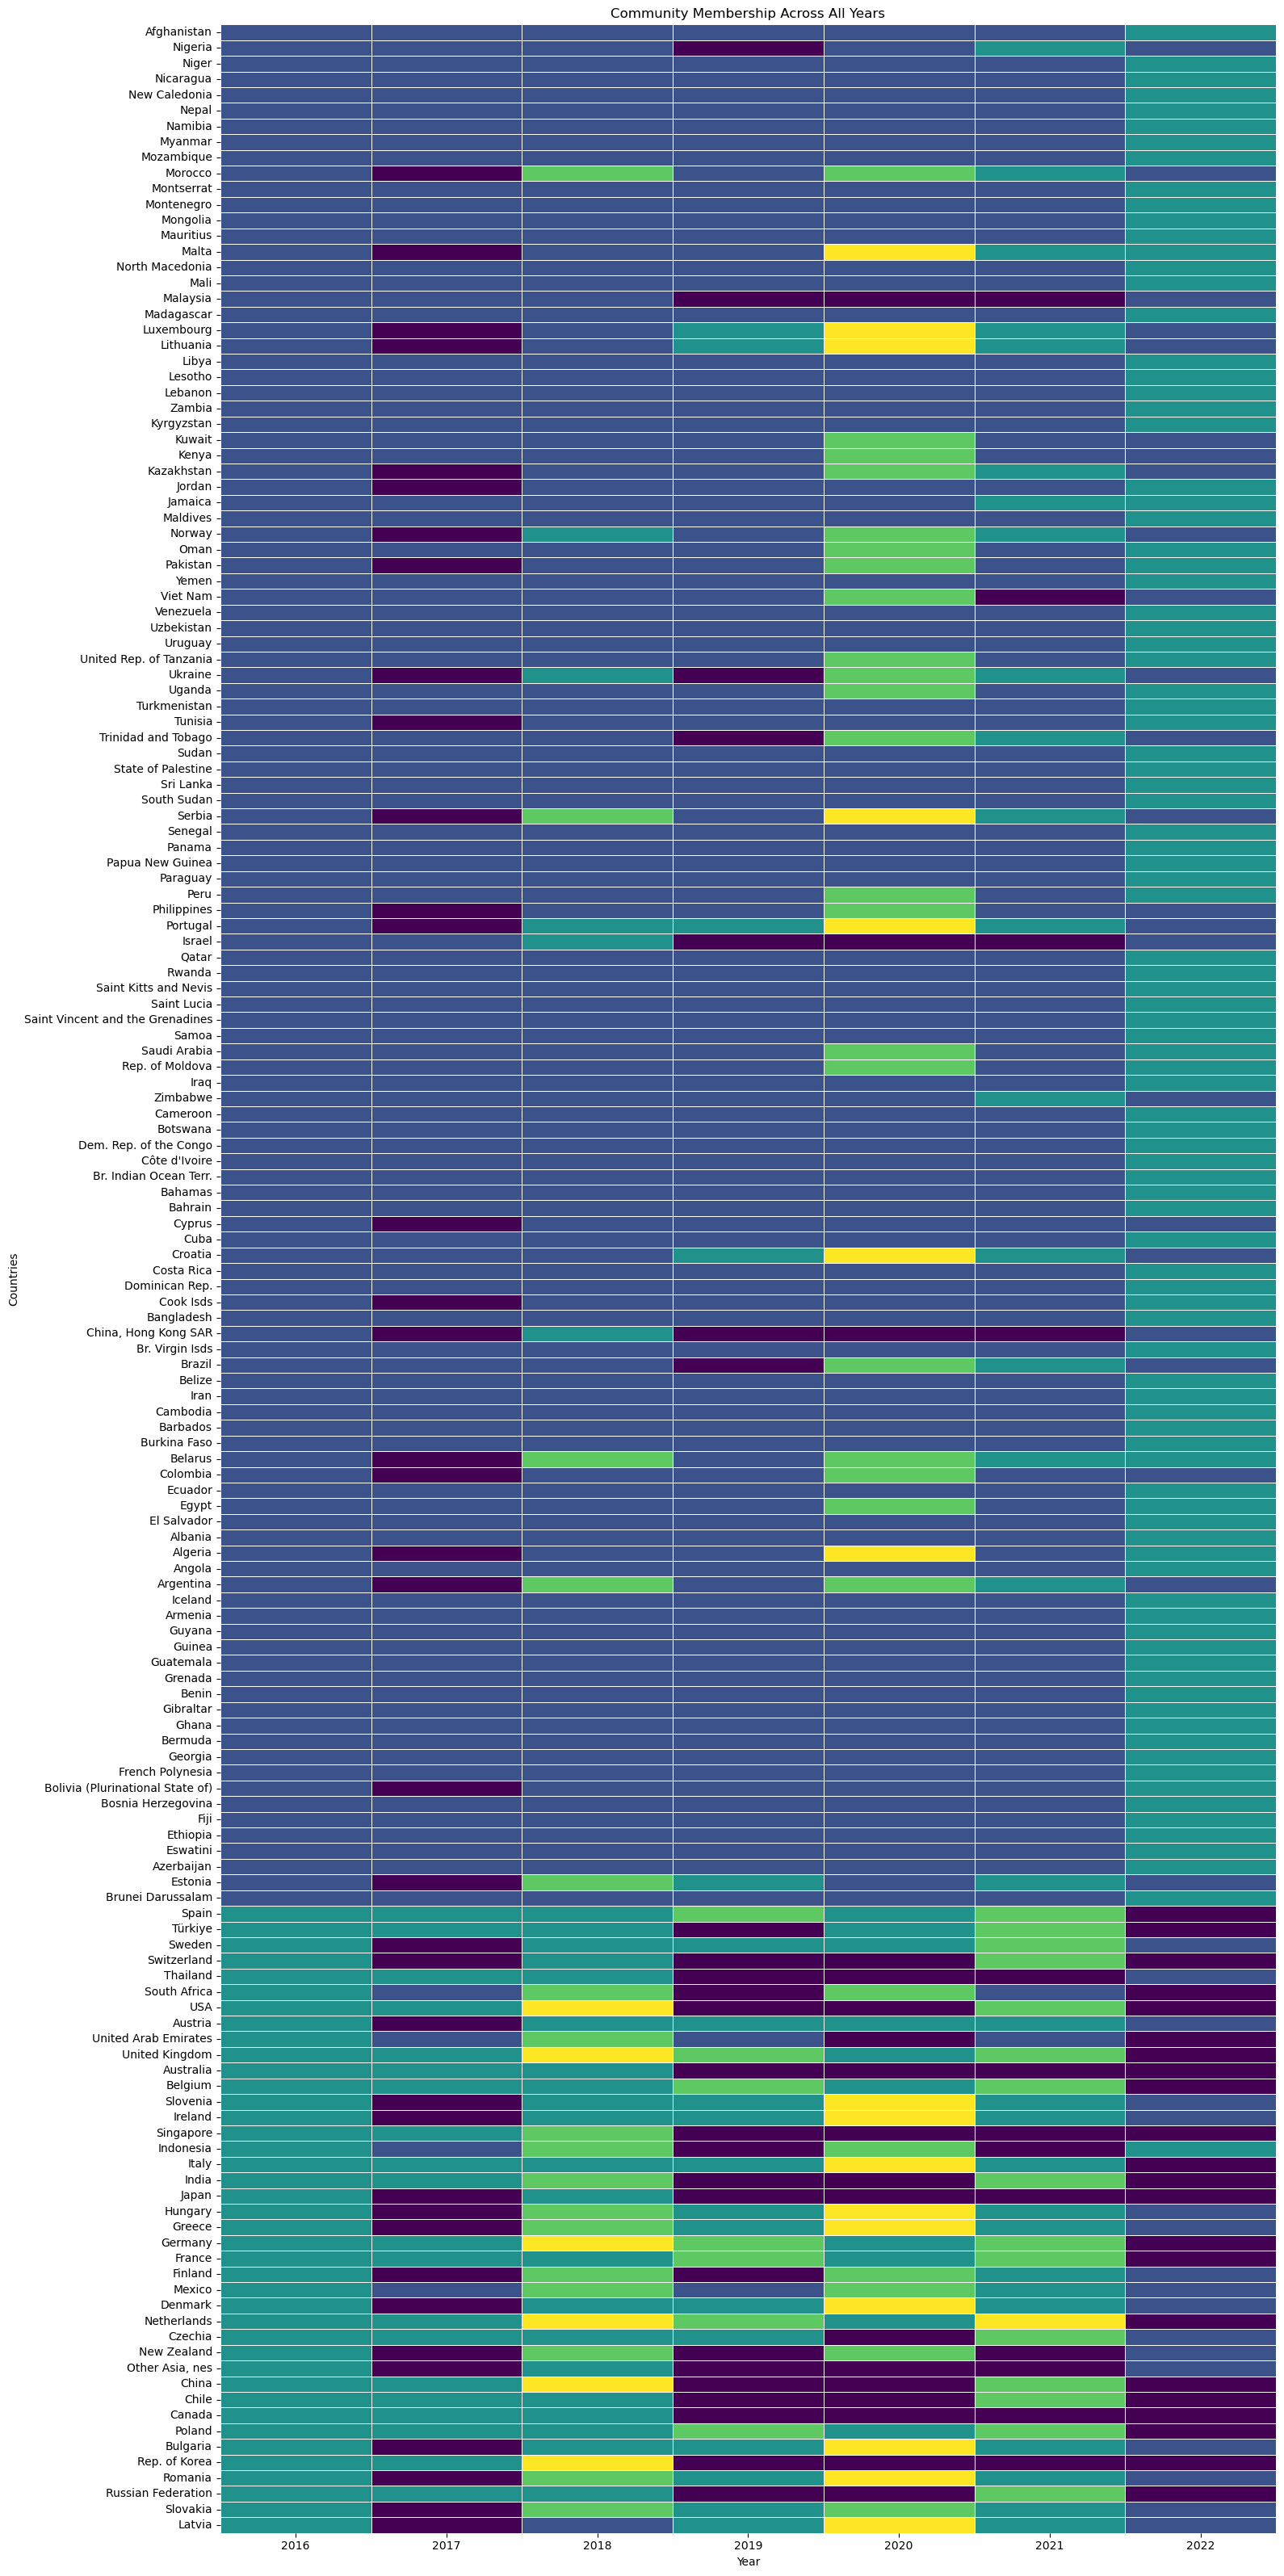

In [ ]:
plot_combined_community_heatmap(return_df)

In [8]:
# Step 1: Prepare the data
data = return_df.copy()

# Step 2: Define outlier years
anomaly_score_path = os.path.join(os.getcwd(), 'full_reconstruction.csv')
anomaly_scores = pd.read_csv(anomaly_score_path).drop(columns='Unnamed: 0')
anomaly_scores.sort_values(by=['normalized_anomaly_score'], ascending=False, inplace=True)
subsample = anomaly_scores[anomaly_scores['product'] == code]
outlier_years = subsample.sort_values(by='year', ascending=True)['year'].tolist()

# Step 3: Define metric columns
metric_columns = ["Betweeness", "Pagerank"]

# Step 4: Apply the function
significant_changes = test_significant_changes(data, outlier_years, metric_columns, country_col="country", alpha=0.05)

# Step 5: Display results
for year, countries in significant_changes.items():
    print(f"Year {year}: Significant changes detected in {len(countries)} countries.")
    print(countries)


Skipping analysis for 2022: Missing columns - Baseline: [], Target: ['2023_Betweeness', '2023_Pagerank']
Year 2017: Significant changes detected in 0 countries.
[]
Year 2018: Significant changes detected in 0 countries.
[]
Year 2019: Significant changes detected in 0 countries.
[]
Year 2020: Significant changes detected in 0 countries.
[]
Year 2021: Significant changes detected in 0 countries.
[]


In [6]:
pathDB = os.path.join(os.getcwd(), 'basedata','Summed Base Data.csv')
df = pd.read_csv(pathDB)
df.rename(columns={'t': 'year', 'v': 'quantity'}, inplace=True)
expanded_years = df['year'].unique().tolist()
df['code'] = 1
gtG = GraphConstructor.GT(df)
visualizer = TradeNetworkVisualizer(gtG, df)

output_path = os.path.join(os.getcwd(), 'graphics','Aggregate SVG')

product_name = "Aggragate trade"
"""
for year in expanded_years:
    visualizer.visualize_product_graph(1, year, return_df)
"""

results = Parallel(n_jobs=-1)(
    delayed(visualizer.visualize_product_graph)(1, year, pd.DataFrame())
    for year in expanded_years
)
# Filter out None values from the results
filtered_results = [df for df in results if df is not None]

# Initialize return_df
return_df = pd.DataFrame()

# Merge all valid DataFrames
for result_df in filtered_results:
    if return_df.empty:
        return_df = result_df
    else:
        return_df = pd.merge(return_df, result_df, how="outer", left_index=True, right_index=True)

# Drop the "country" column if it exists
if "country" in return_df.columns:
    return_df = return_df.drop(columns=["country"])


Aggragate trade communities for year 2001
Aggragate trade communities for year 2002
Aggragate trade communities for year 2004
Aggragate trade communities for year 2006
Aggragate trade communities for year 2003
Aggragate trade communities for year 2005
Aggragate trade communities for year 2008
Aggragate trade communities for year 2007
Aggragate trade communities for year 2009


/opt/anaconda3/envs/TradeFlowProject/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(

(ipykernel_launcher.py:38227): Gdk-WARNING **: 12:20:40.270: Failed to initialize CVDisplayLink!


Aggragate trade communities for year 2013
Aggragate trade communities for year 2012
Aggragate trade communities for year 2014
Aggragate trade communities for year 2011
Aggragate trade communities for year 2010


/opt/anaconda3/envs/TradeFlowProject/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(

(ipykernel_launcher.py:44747): Gdk-WARNING **: 13:06:23.244: Failed to initialize CVDisplayLink!


Aggragate trade communities for year 2015
Aggragate trade communities for year 2017
Aggragate trade communities for year 2016
Aggragate trade communities for year 2022
Aggragate trade communities for year 2018
Aggragate trade communities for year 2019
Aggragate trade communities for year 2020
Aggragate trade communities for year 2021


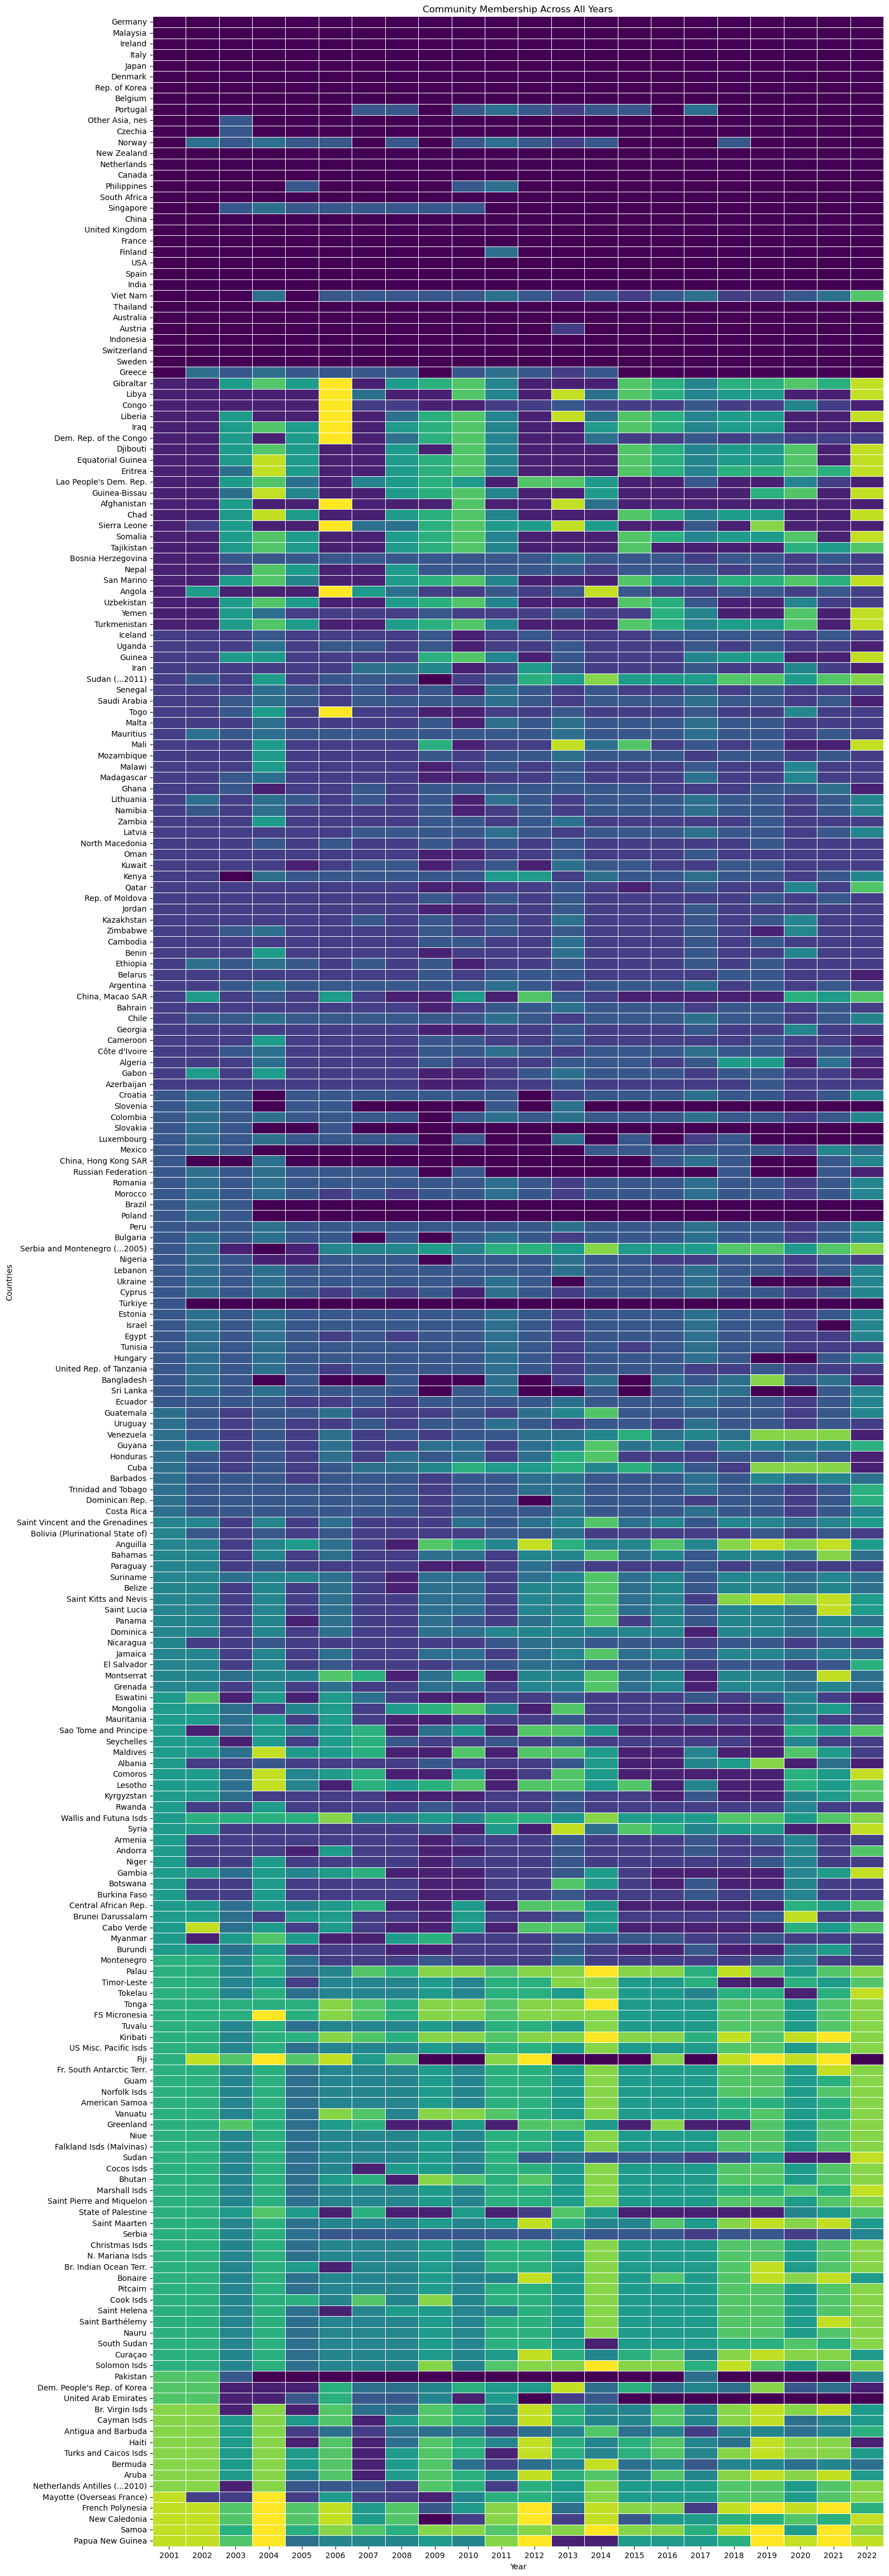

In [7]:
plot_combined_community_heatmap(return_df)

In [9]:
data = return_df.copy()

# Step 2: Define outlier years
outlier_years=[2007, 2008, 2014, 2017, 2018, 2019, 2020, 2021]

# Step 3: Define metric columns
metric_columns = ["Betweeness", "Pagerank"]

# Step 4: Apply the function
significant_changes = test_significant_changes(data, outlier_years, metric_columns, country_col="country", alpha=0.05)

# Step 5: Display results
for year, countries in significant_changes.items():
    print(f"Year {year}: Significant changes detected in {len(countries)} countries.")
    print(countries)


Year 2007: Significant changes detected in 231 countries.
['Poland', 'Haiti', 'Equatorial Guinea', 'Iran', 'Kenya', 'Thailand', 'Greenland', "Lao People's Dem. Rep.", 'Russian Federation', 'US Misc. Pacific Isds', 'Rep. of Korea', 'Sudan (...2011)', 'Morocco', 'Iraq', 'Cambodia', 'Montserrat', 'Belarus', 'Togo', 'Bangladesh', 'Honduras', 'Solomon Isds', 'Mayotte (Overseas France)', 'Spain', 'Dominican Rep.', 'Saint Maarten', "Côte d'Ivoire", 'Gambia', 'Singapore', 'Nicaragua', 'Senegal', 'Burundi', 'Other Asia, nes', 'Cyprus', 'Belgium', 'Chad', 'Bahrain', 'Dominica', 'France', 'Uzbekistan', 'Fiji', 'Br. Virgin Isds', 'Aruba', 'Bulgaria', 'Kazakhstan', 'Madagascar', 'Nauru', 'Azerbaijan', 'Bermuda', 'Iceland', 'Libya', 'Guatemala', 'Montenegro', 'Seychelles', 'Turks and Caicos Isds', 'Ukraine', 'Germany', 'Wallis and Futuna Isds', 'Br. Indian Ocean Terr.', 'Malawi', 'Türkiye', 'Christmas Isds', 'Kyrgyzstan', 'Cameroon', 'Egypt', 'Zambia', 'Fr. South Antarctic Terr.', 'Nigeria', 'Guyana

In [ ]:
output_path = os.path.join(os.getcwd(), 'graphics', 'aggregated bis SVG')
years = []
treated_years = []

# Fill the years list
for i in range(1995, 2022):
    years.append(i)

# Group years by 3 and handle remainder
for i in range(len(years) // 3):
    treated_years.append([years[i * 3], years[i * 3 + 1], years[i * 3 + 2]])

if len(years) % 3 != 0:
    treated_years.append(years[-(len(years) % 3):])

# Define the processing function
def getting_and_processing(year_exp, return_df):
    year_placeholder = ", ".join(map(str, year_exp))  # Convert list to comma-separated string
    query = f"""
        SELECT
            year,
            import_country,
            export_country,
            SUM(quantity) AS quantity,
            SUM(value) AS value
        FROM
            base_data
        WHERE
            year IN ({year_placeholder})
        GROUP BY
            year, import_country, export_country, code
        ORDER BY
            year;
    """

    with sqlite3.connect(pathDB) as conn:
        df = pd.read_sql_query(query, conn)
    df['code'] = 1
    gtG = GraphConstructor.GT(df)
    visualizer = TradeNetworkVisualizer(gtG, df)

    for year in year_exp:
        return_df = visualizer.visualize_product_graph(1, year, return_df)

    return return_df

# Process in parallel
results = Parallel(n_jobs=-2)(
    delayed(getting_and_processing)(years_exp, pd.DataFrame())
    for years_exp in treated_years
)
# Filter out None values from the results
filtered_results = [df for df in results if df is not None]

# Initialize return_df
return_df = pd.DataFrame()

# Merge all valid DataFrames
for result_df in filtered_results:
    if return_df.empty:
        return_df = result_df
    else:
        return_df = pd.merge(return_df, result_df, how="outer", left_index=True, right_index=True)

# Drop the "country" column if it exists
if "country" in return_df.columns:
    return_df = return_df.drop(columns=["country"])

In [ ]:
plot_combined_community_heatmap(return_df)

In [ ]:
data = return_df.copy()

# Step 2: Define outlier years
outlier_years=['2007', '2008', '2014', '2017', '2018', '2019', '2020', '2021']

# Step 3: Define metric columns
metric_columns = ["Betweeness", "Pagerank"]

# Step 4: Apply the function
significant_changes = test_significant_changes(data, outlier_years, metric_columns, country_col="country", alpha=0.05)

# Step 5: Display results
for year, countries in significant_changes.items():
    print(f"Year {year}: Significant changes detected in {len(countries)} countries.")
    print(countries)
